In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
import graphviz
import os
from sklearn import preprocessing
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

/usr/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
current_dir = r'/home/yw/study/Competition/Avito-Demand-Prediction-Challenge'
data_dirs = dict()
data_dirs['train_data'] = os.path.join(current_dir, 'data/train.csv')
data_dirs['test_data'] = os.path.join(current_dir, 'data/test.csv')
data_dirs['pred_result'] = os.path.join(current_dir, 'data/lightGBM_04_01.csv')
data_dirs['model_path'] = os.path.join(current_dir, 'data/model_data/lightGBM_04.pkl')

In [7]:
def prepare_data(data_dirs):
    train_df = pd.read_csv(data_dirs['train_data'], parse_dates=["activation_date"])
    test_df = pd.read_csv(data_dirs['test_data'], parse_dates=["activation_date"])
    
    use_features = set()

    train_y = train_df["deal_probability"].values
    test_id = test_df["item_id"].values
    # explore features
    # weekday
    train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
    test_df["activation_weekday"] = test_df["activation_date"].dt.weekday
    # hour
    train_df['activation_hour'] = train_df["activation_date"].dt.hour
    test_df['activation_hour'] = test_df["activation_date"].dt.hour
    
    use_features.update(['activation_weekday','activation_hour'])
    
    # Label encode the categorical variables #
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    for col in cat_vars:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
    use_features.update(cat_vars)
    
    # title length
    train_df['title_len'] = train_df['title'].apply(len)
    test_df['title_len'] = test_df['title'].apply(len)
    # description length
    train_df['descrip_len'] = train_df['description'].apply(lambda x: 0 if x is np.nan else len(x))
    test_df['descrip_len'] = test_df['description'].apply(lambda x: 0 if x is np.nan else len(x))
    
    use_features.update(['title_len', 'descrip_len'])
    use_features.update(['price', 'item_seq_number', 'image_top_1'])
    use_features=list(use_features)
    train_X = train_df[use_features]
    test_X = test_df[use_features]
    return train_X, train_y, test_X, test_id, cat_vars+['activation_weekday','activation_hour']

In [8]:
train_X, train_y, test_X, test_id, cat_vars= prepare_data(data_dirs)

In [9]:
X_train,X_val,y_train,y_val=train_test_split(train_X,train_y,test_size=0.20,random_state=9)

# 1 Base line

In [11]:
def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='rmse',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['rmse-mean']))
        print('Best Iteration:',len(cvresult['rmse-mean']))
        
    alg.fit(X,y,eval_metric='rmse',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y,dtrain_predictions))))
    print('Model report on test:')
    print('Test RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test,dtest_predictions))))
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='rmse',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='rmse',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

In [ ]:
params={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':8,
        'learning_rate':0.3,
        'n_estimators':1000,
        'max_bin':255,
        'objective':'regression',
        'min_split_gain':1,
        'min_child_weight':5,
        'min_child_samples':1,
        'subsample':0.8,
        'subsample_freq':1,
        'colsample_bytree':0.8,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':-1,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':8,
        'learning_rate':0.3,
        'max_bin':255,
        'objective':'regression',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.8,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':-1,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [14]:
lgbr=lgb.LGBMRegressor(**params)

/usr/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[20]	cv_agg's rmse: 0.229311 + 0.00125648
[40]	cv_agg's rmse: 0.228667 + 0.00126568
[60]	cv_agg's rmse: 0.228637 + 0.00128104
[80]	cv_agg's rmse: 0.228667 + 0.00128271
Best Iteration: 62


/usr/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['activation_hour', 'activation_weekday', 'category_name', 'city', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Model report on trian:
Train RMSE:0.2239
Model report on test:
Test RMSE:0.2285


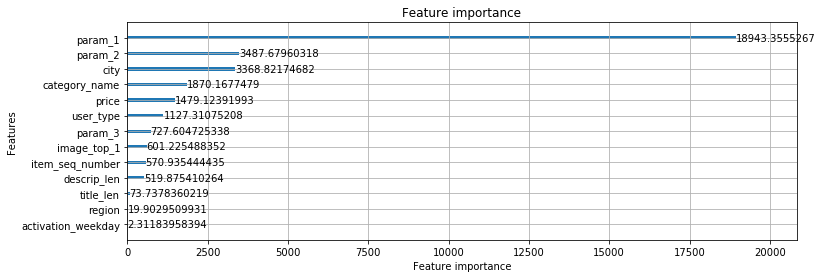

In [15]:
get_lgb_params(lgbr.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [16]:
params['n_estimators']=62

# 2 Tune params

In [17]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

In [18]:
def rmse(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))
scorer = metrics.make_scorer(rmse, greater_is_better=False)

## 2.1 max_depth

In [21]:
searchParam={'max_depth':[2,3,4,5,6,7,8,9,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 9
Best score: -0.228641824711
    mean_test_score  mean_train_score  std_test_score  std_train_score
2         -0.231681         -0.230973        0.000858         0.000194
3         -0.230075         -0.228346        0.000770         0.000257
4         -0.229407         -0.226163        0.000800         0.000208
5         -0.229026         -0.224443        0.000827         0.000180
6         -0.228893         -0.223752        0.000765         0.000262
7         -0.228786         -0.223583        0.000788         0.000141
8         -0.228649         -0.223378        0.000821         0.000285
9         -0.228642         -0.223280        0.000857         0.000186
10        -0.228651         -0.223332        0.000816         0.000237


## 2.2 num_leaves

In [23]:
searchParam={'num_leaves':(20,25,30,35,40,50)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 35
Best score: -0.228568149098
    mean_test_score  mean_train_score  std_test_score  std_train_score
20        -0.228763         -0.224536        0.000874         0.000195
25        -0.228653         -0.223832        0.000796         0.000261
30        -0.228642         -0.223280        0.000857         0.000186
35        -0.228568         -0.222993        0.000804         0.000281
40        -0.228633         -0.222632        0.000809         0.000199
50        -0.228600         -0.222324        0.000788         0.000226


## 2.3 subsample

In [23]:
searchParam={'subsample':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 0.9
Best score: -0.229278048902
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1        -0.233881         -0.231130        0.000716         0.000321
0.3        -0.230967         -0.227892        0.000896         0.000230
0.5        -0.230218         -0.227104        0.000758         0.000204
0.7        -0.229700         -0.226472        0.000954         0.000082
0.9        -0.229278         -0.226437        0.000787         0.000258
1.0        -0.229441         -0.227139        0.000809         0.000328


In [24]:
searchParam={'subsample':[0.88,0.89,0.9,0.91,0.92]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 0.9
Best score: -0.22838716759
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.88        -0.228570         -0.223471        0.000793         0.000269
0.89        -0.228420         -0.223408        0.000734         0.000263
0.90        -0.228387         -0.223367        0.000763         0.000336
0.91        -0.228531         -0.223793        0.000857         0.000265
0.92        -0.228470         -0.223827        0.000815         0.000254


In [27]:
searchParam={'subsample':[0.85,0.87,0.88,0.885]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 0.88
Best score: -0.229257495593
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.850        -0.229444         -0.226215        0.000923         0.000195
0.870        -0.229370         -0.226301        0.000890         0.000228
0.880        -0.229257         -0.226336        0.000786         0.000323
0.885        -0.229332         -0.226523        0.000860         0.000219


## 2.4 subsample_freq

In [28]:
searchParam={'subsample_freq':[1,2,3,4,5,6,7,8,9]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample_freq : 1
Best score: -0.229257495593
   mean_test_score  mean_train_score  std_test_score  std_train_score
1        -0.229257         -0.226336        0.000786         0.000323
2        -0.229425         -0.226583        0.000827         0.000241
3        -0.229316         -0.226504        0.000841         0.000294
4        -0.229406         -0.226717        0.000800         0.000331
5        -0.229599         -0.226965        0.000864         0.000261
6        -0.229510         -0.226922        0.000888         0.000080
7        -0.229540         -0.226987        0.000884         0.000145
8        -0.229432         -0.226944        0.000908         0.000349
9        -0.229517         -0.226970        0.000827         0.000207


## 2.5 colsample_bytree

In [29]:
searchParam={'colsample_bytree':[0.1,0.3,0.5,0.7,0.8,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.8
Best score: -0.229257495593
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1        -0.235373         -0.235124        0.000824         0.000205
0.3        -0.230049         -0.228697        0.000838         0.000197
0.5        -0.229624         -0.227590        0.000725         0.000293
0.7        -0.229315         -0.226684        0.000771         0.000281
0.8        -0.229257         -0.226336        0.000786         0.000323
0.9        -0.229480         -0.225914        0.000830         0.000170
1.0        -0.229601         -0.225376        0.000847         0.000213


## 2.6 reg_alpha

In [32]:
searchParam={'reg_alpha':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_alpha : 0
Best score: -0.229257495593
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.229257         -0.226336        0.000786         0.000323
0.00001         -0.229257         -0.226336        0.000786         0.000323
0.00100         -0.229257         -0.226336        0.000786         0.000323
0.10000         -0.229343         -0.226344        0.000864         0.000120
0.50000         -0.229322         -0.226444        0.000855         0.000237
1.00000         -0.229376         -0.226422        0.000770         0.000233
3.00000         -0.229376         -0.226564        0.000828         0.000157
5.00000         -0.229433         -0.226735        0.000818         0.000203
10.00000        -0.229357         -0.226836        0.000832         0.000176


## 2.7 reg_lambda

In [34]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 0.1
Best score: -0.229227075495
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.229257         -0.226336        0.000786         0.000323
0.00001         -0.229257         -0.226336        0.000786         0.000323
0.00100         -0.229257         -0.226336        0.000786         0.000323
0.10000         -0.229227         -0.226295        0.000836         0.000182
0.50000         -0.229321         -0.226412        0.000711         0.000401
1.00000         -0.229349         -0.226327        0.000770         0.000262
3.00000         -0.229340         -0.226305        0.000749         0.000323
5.00000         -0.229293         -0.226250        0.000863         0.000139
10.00000        -0.229236         -0.226299        0.000817         0.000154


## 2.8 min_child_samples

In [27]:
searchParam={'min_child_samples':[1,2,5,10,20,30,50,100]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 30
Best score: -0.228366227091
     mean_test_score  mean_train_score  std_test_score  std_train_score
1          -0.228387         -0.223367        0.000763         0.000336
2          -0.228387         -0.223367        0.000763         0.000336
5          -0.228387         -0.223367        0.000763         0.000336
10         -0.228387         -0.223367        0.000763         0.000336
20         -0.228423         -0.223652        0.000734         0.000453
30         -0.228366         -0.223477        0.000771         0.000288
50         -0.228446         -0.223573        0.000705         0.000325
100        -0.228472         -0.223767        0.000785         0.000332


In [172]:
searchParam={'min_child_samples':[3,4,5,6,7]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 3
Best score: 0.63428579984
   mean_test_score  mean_train_score  std_test_score  std_train_score
3         0.634286          0.676859        0.002134         0.001064
4         0.634286          0.676859        0.002134         0.001064
5         0.634286          0.676859        0.002134         0.001064
6         0.634286          0.676859        0.002134         0.001064
7         0.634286          0.676859        0.002134         0.001064


## 2.9 min_child_weight

In [173]:
searchParam={'min_child_weight':[1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 1e-05
Best score: 0.63428579984
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00001         0.634286          0.676859        0.002134         0.001064
0.00100         0.634286          0.676859        0.002134         0.001064
0.10000         0.634286          0.676859        0.002134         0.001064
0.50000         0.634286          0.676859        0.002134         0.001064
1.00000         0.634286          0.676859        0.002134         0.001064
3.00000         0.634286          0.676859        0.002134         0.001064
5.00000         0.634286          0.676859        0.002134         0.001064


## 2.10 max_bin

In [174]:
searchParam={'max_bin':[31,63,127,255,511]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_bin : 255
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
31          0.632909          0.675524        0.002234         0.001220
63          0.633120          0.675998        0.001408         0.000908
127         0.633413          0.676443        0.002107         0.001359
255         0.634286          0.676859        0.002134         0.001064
511         0.632746          0.676565        0.001914         0.001183


## 2.11 min_split_gain

In [183]:
searchParam={'min_split_gain':[0.5,0.9,1,1.1,2,3]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 1
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5         0.634007          0.676327        0.002064         0.000875
0.9         0.634016          0.676880        0.002242         0.001080
1.0         0.634286          0.676859        0.002134         0.001064
1.1         0.633735          0.676845        0.002634         0.001043
2.0         0.634004          0.676904        0.001815         0.001361
3.0         0.633310          0.676621        0.001720         0.001495


## 2.12 lower learning_rate

[20]	cv_agg's rmse: 0.251917 + 0.00153121
[40]	cv_agg's rmse: 0.246151 + 0.00150301
[60]	cv_agg's rmse: 0.242009 + 0.00146759
[80]	cv_agg's rmse: 0.239072 + 0.00143818
[100]	cv_agg's rmse: 0.236906 + 0.00141288
[120]	cv_agg's rmse: 0.235311 + 0.00139108
[140]	cv_agg's rmse: 0.234124 + 0.0013653
[160]	cv_agg's rmse: 0.233193 + 0.00134525
[180]	cv_agg's rmse: 0.23247 + 0.00132646
[200]	cv_agg's rmse: 0.231904 + 0.00131174
[220]	cv_agg's rmse: 0.231434 + 0.00129734
[240]	cv_agg's rmse: 0.231078 + 0.00128433
[260]	cv_agg's rmse: 0.230787 + 0.00127815
[280]	cv_agg's rmse: 0.230502 + 0.0012689
[300]	cv_agg's rmse: 0.230254 + 0.00126562
[320]	cv_agg's rmse: 0.230047 + 0.00125545
[340]	cv_agg's rmse: 0.229853 + 0.00125165
[360]	cv_agg's rmse: 0.229693 + 0.00124296
[380]	cv_agg's rmse: 0.229545 + 0.00123786
[400]	cv_agg's rmse: 0.229425 + 0.00122966
[420]	cv_agg's rmse: 0.2293 + 0.00122443
[440]	cv_agg's rmse: 0.229187 + 0.00122375
[460]	cv_agg's rmse: 0.229089 + 0.00122267
[480]	cv_agg's rmse:

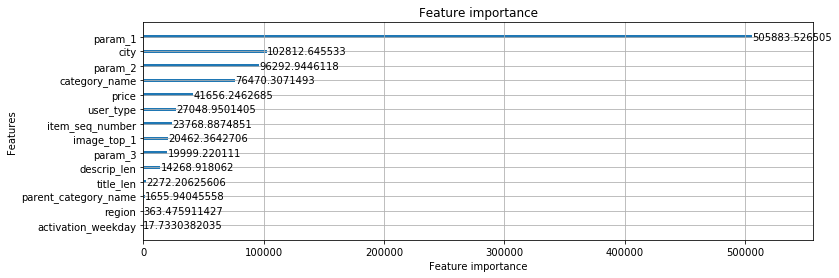

In [28]:
params['learning_rate']=0.01
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.236703 + 0.00139293
[40]	cv_agg's rmse: 0.231819 + 0.00130524
[60]	cv_agg's rmse: 0.230283 + 0.00127033
[80]	cv_agg's rmse: 0.229483 + 0.00124622
[100]	cv_agg's rmse: 0.22899 + 0.00123823
[120]	cv_agg's rmse: 0.228651 + 0.00123133
[140]	cv_agg's rmse: 0.228391 + 0.00124692
[160]	cv_agg's rmse: 0.228186 + 0.00126727
[180]	cv_agg's rmse: 0.228085 + 0.00125273
[200]	cv_agg's rmse: 0.228063 + 0.0012526
[220]	cv_agg's rmse: 0.228063 + 0.0012526
Best Iteration: 200
Model report on trian:
Train RMSE:0.2240
Model report on test:
Test RMSE:0.2277


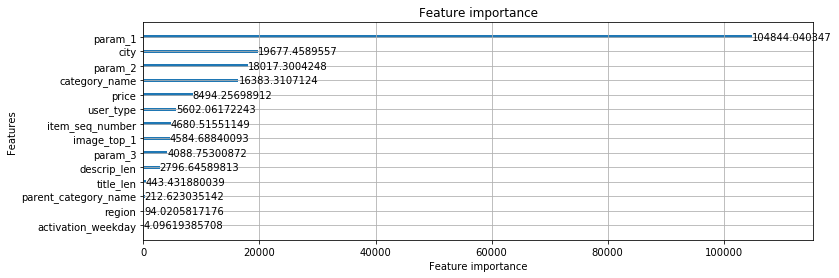

In [31]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [32]:
params['n_estimators']=200

# 3 Final model

In [33]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 9,
 'min_child_samples': 30,
 'min_child_weight': 5,
 'min_split_gain': 1,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 35,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.9,
 'subsample_freq': 1}

In [34]:
lgbr_opt=lgb.LGBMRegressor(**params)

In [35]:
lgbr_opt.fit(train_X,train_y,feature_name=list(train_X.columns),categorical_feature=cat_vars)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
       learning_rate=0.05, max_bin=255, max_depth=9, min_child_samples=30,
       min_child_weight=5, min_split_gain=1, n_estimators=200, n_jobs=-1,
       num_leaves=35, objective='regression', random_state=9, reg_alpha=0,
       reg_lambda=0, silent=True, subsample=0.9, subsample_for_bin=50000,
       subsample_freq=1)

In [37]:
pred_test=lgbr_opt.predict(test_X)

In [266]:
pred_test[pred_test > 1] = 1
pred_test[pred_test < 0] = 0
sub_df = pd.DataFrame({"item_id": test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv(data_dirs['pred_result'], index=False)

In [267]:
predict_result.head()

,id,target
0,0,0.448932
1,1,0.448197
2,2,0.417098
3,3,0.314295
4,4,0.505310


In [268]:
predict_result.to_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/20171030_12lgbm.csv',index=False)